# <center>Image Segmentation with U-Net</center>

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center>Example of a segmented image</center></caption>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,  Conv2D, Conv2DTranspose, concatenate, Dropout, MaxPooling2D

In [2]:
image_dir = 'data/CameraRGB/'
mask_dir = 'data/CameraMask/'

image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_files  = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [3]:
print('Total Images:', len(image_files))

Total Images: 1060


Size of Image: (480, 640, 3)
Size of Mask: (480, 640)


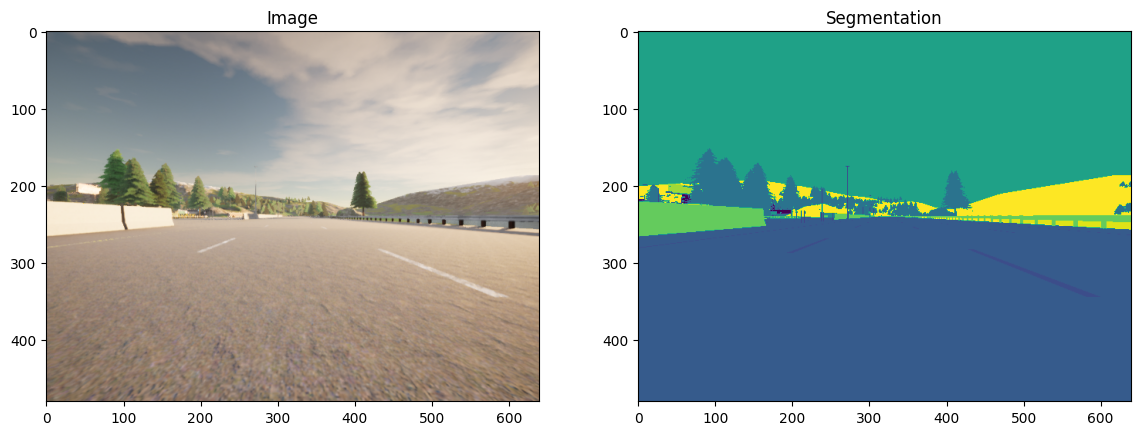

In [4]:
N = 5
img = imageio.imread(image_files[N])[:, :, :3]
mask = imageio.imread(mask_files[N])[:, :,0]
print('Size of Image:', img.shape)
print('Size of Mask:', mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')
plt.show()

## Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center>U-Net Architecture<br> </center></caption>

In [5]:
def load_image(img_path, mask_path, img_size=(96, 128)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest') 
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    return img, mask

In [6]:
img, mask = load_image(image_files[0], mask_files[0])
print(img.shape)
print(mask.shape)

(96, 128, 3)
(96, 128, 1)


In [7]:
def get_dataset(image_files, mask_files, batch_size=32, img_size=(96, 128)):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: load_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
train_dataset = get_dataset(image_files, mask_files)

(32, 96, 128, 3)
(32, 96, 128, 1)


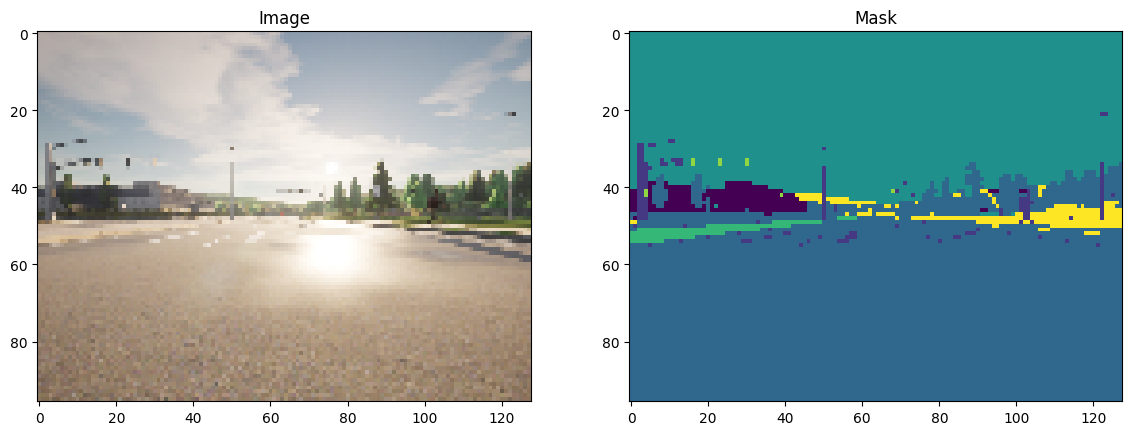

In [9]:
for images, masks in train_dataset.take(1):
    print(images.shape)
    print(masks.shape)
    
    plt.figure(figsize=(14, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0])
    plt.title("Mask")
    plt.show()

## conv_block

## Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center>The U-Net Encoder up close <br> </center></caption>

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Builds a convolutional downsampling block for the U-Net encoder.

    This block applies two Conv2D layers with ReLU activation, optional dropout,
    and optional MaxPooling2D for spatial downsampling.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, H, W, C).
        n_filters (int): Number of filters for both Conv2D layers.
        dropout_prob (float): Dropout rate applied after Conv2D layers if > 0.
        max_pooling (bool): If True, applies MaxPooling2D with pool size = 2 and strides=2
                            to downsample the spatial dimensions.

    Returns:
        next_layer (tf.Tensor): 
            - If max_pooling is True: shape → (batch_size, H/2, W/2, n_filters)
            - Else: shape → (batch_size, H, W, n_filters)
        
        skip_connection (tf.Tensor): Output before pooling, used in skip connection.
            - shape → (batch_size, H, W, n_filters)
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## upsampling_block

## Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, we'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center>The U-Net Decoder up close <br> </center></caption>

In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Builds an upsampling block for the U-Net decoder.

    Applies transpose convolution to upscale the input, concatenates it with
    the corresponding encoder output (skip connection), and applies two Conv2D layers.

    Args:
        expansive_input (tf.Tensor): Decoder input tensor, shape (B, H, W, C).
        contractive_input (tf.Tensor): Encoder skip connection tensor, shape (B, H, W, C).
        n_filters (int): Number of filters for the Conv2D layers.

    Returns:
        tf.Tensor: Output tensor of shape (B, H*2, W*2, n_filters).
    """
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

## Model Building

In [12]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23, debug=False):
    """
    Builds a U-Net model for semantic segmentation.

    U-Net follows an encoder–decoder architecture:
    - The encoder path (contracting) applies repeated 3x3 Conv + ReLU + MaxPool to extract spatial features while reducing resolution.
    - The decoder path (expanding) upsamples the feature maps using transpose convolutions, and merges them with corresponding encoder features (skip connections) to recover spatial details.
    - A final 1x1 convolution maps the features to the desired number of output classes.

    Args:
        input_size (tuple): Shape of the input image (height, width, channels).
        n_filters (int): Number of filters for the first conv block (doubles at each level).
        n_classes (int): Number of segmentation output classes.

    Returns:
        tf.keras.Model: Compiled U-Net model.
    """

    inputs = Input(input_size)
    if debug: print("Input:", inputs.shape)

    cblock1 = conv_block(inputs, n_filters)
    if debug: print("After cblock1:", cblock1[0].shape, "(skip:", cblock1[1].shape, ")")

    cblock2 = conv_block(cblock1[0], n_filters*2)
    if debug: print("After cblock2:", cblock2[0].shape, "(skip:", cblock2[1].shape, ")")

    cblock3 = conv_block(cblock2[0], n_filters*4)
    if debug: print("After cblock3:", cblock3[0].shape, "(skip:", cblock3[1].shape, ")")

    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    if debug: print("After cblock4:", cblock4[0].shape, "(skip:", cblock4[1].shape, ")")

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    if debug: print("After cblock5 (bottom):", cblock5[0].shape)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    if debug: print("After ublock6:", ublock6.shape)

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    if debug: print("After ublock7:", ublock7.shape)

    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    if debug: print("After ublock8:", ublock8.shape)

    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    if debug: print("After ublock9:", ublock9.shape)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    if debug: print("After conv9:", conv9.shape)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    if debug: print("Final Output:", conv10.shape)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), debug=True)

Input: (None, 96, 128, 3)
After cblock1: (None, 48, 64, 32) (skip: (None, 96, 128, 32) )
After cblock2: (None, 24, 32, 64) (skip: (None, 48, 64, 64) )
After cblock3: (None, 12, 16, 128) (skip: (None, 24, 32, 128) )
After cblock4: (None, 6, 8, 256) (skip: (None, 12, 16, 256) )
After cblock5 (bottom): (None, 6, 8, 512)
After ublock6: (None, 12, 16, 256)
After ublock7: (None, 24, 32, 128)
After ublock8: (None, 48, 64, 64)
After ublock9: (None, 96, 128, 32)
After conv9: (None, 96, 128, 32)
Final Output: (None, 96, 128, 23)


In [86]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 96, 128, 32)  896         ['input_4[0][0]']                
                                                                                                  
 conv2d_61 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_60[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_61[0][0]']        

                                                                                                  
 conv2d_79 (Conv2D)             (None, 96, 128, 23)  759         ['conv2d_78[0][0]']              
                                                                                                  
Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [87]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = 'adam'
unet.compile(optimizer=opt, loss=loss, metrics='accuracy')

In [88]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(96, 128, 3)
(96, 128, 1)


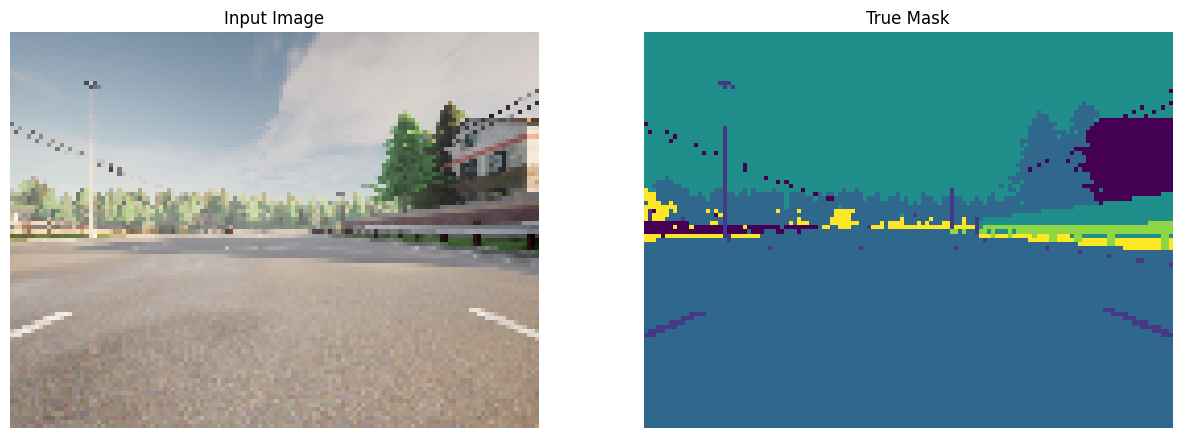

In [89]:
for img, mask in train_dataset.take(1):
    image, mask = img[0], mask[0]
    print(image.shape)
    print(mask.shape)

display([image, mask])

## Train the Model

In [90]:
train_dataset = get_dataset(image_files, mask_files, batch_size=32, img_size=(96, 128))

In [ ]:
init_epochs = 10

In [92]:
init_history = unet.fit(train_dataset, epochs=init_epochs)

Epoch 1/10
34/34 [==============================] - 11s 260ms/step - loss: 1.6439 - accuracy: 0.4560
Epoch 2/10
34/34 [==============================] - 11s 265ms/step - loss: 0.9133 - accuracy: 0.7149
Epoch 3/10
34/34 [==============================] - 11s 270ms/step - loss: 0.5574 - accuracy: 0.8383
Epoch 4/10
34/34 [==============================] - 11s 267ms/step - loss: 0.5153 - accuracy: 0.8458
Epoch 5/10
34/34 [==============================] - 11s 272ms/step - loss: 0.5264 - accuracy: 0.8437
Epoch 6/10
34/34 [==============================] - 11s 272ms/step - loss: 0.4884 - accuracy: 0.8609
Epoch 7/10
34/34 [==============================] - 11s 265ms/step - loss: 0.4453 - accuracy: 0.8703
Epoch 8/10
34/34 [==============================] - 11s 263ms/step - loss: 0.3820 - accuracy: 0.8805
Epoch 9/10
34/34 [==============================] - 11s 267ms/step - loss: 0.3468 - accuracy: 0.8926
Epoch 10/10
34/34 [==============================] - 11s 263ms/step - loss: 0.3317 - accura

In [93]:
def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(epochs, history['loss'], 'b-', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(epochs, history['accuracy'], 'g-', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='g')
    ax2.tick_params('y', colors='g')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()


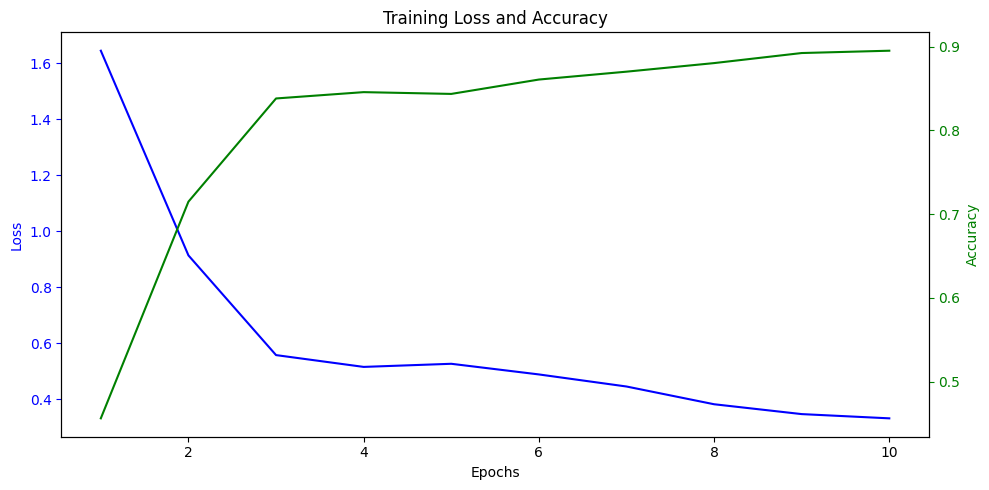

In [94]:
plot_training_history(init_history.history)

In [95]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [96]:
def show_predictions(dataset=None, num=5):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in train_dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 209ms/step


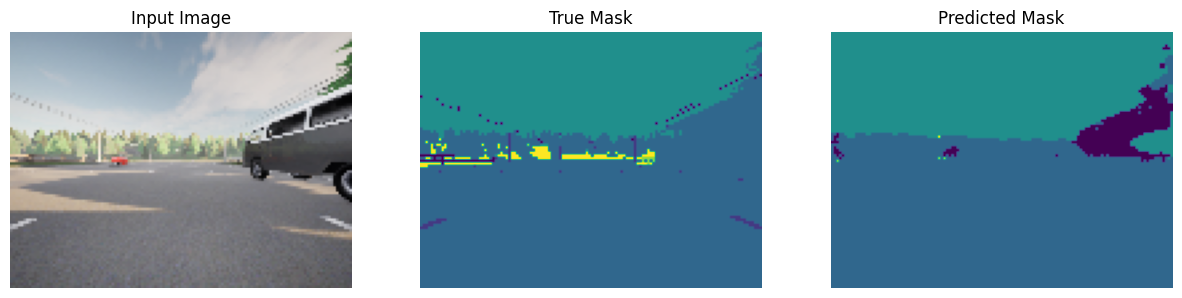

1/1 [==============================] - 0s 25ms/step


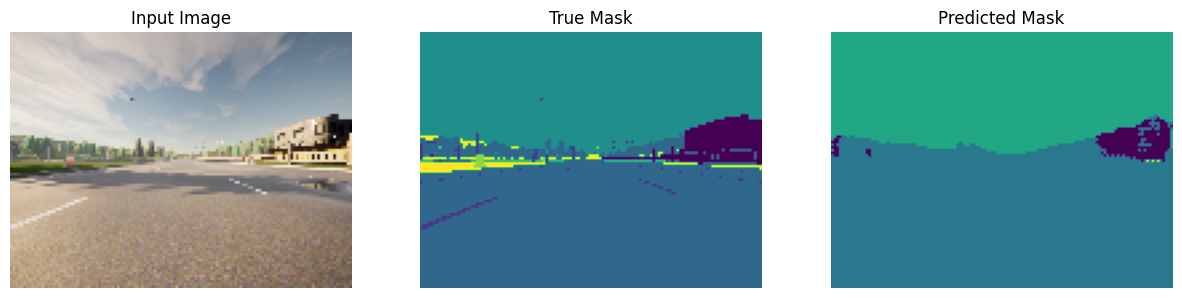

1/1 [==============================] - 0s 24ms/step


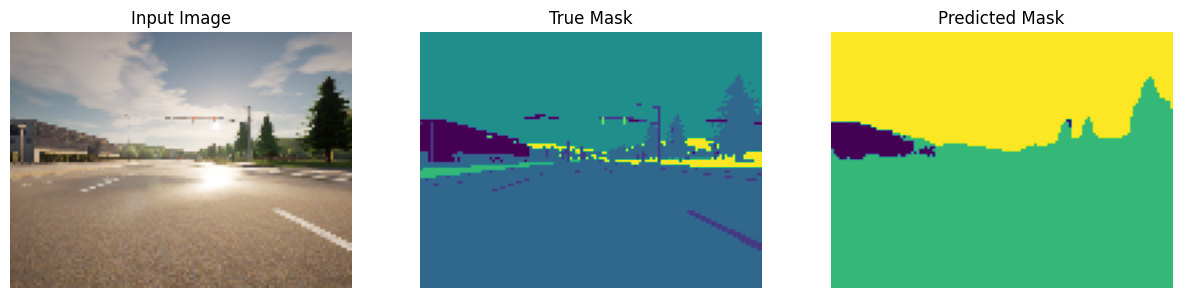

1/1 [==============================] - 0s 116ms/step


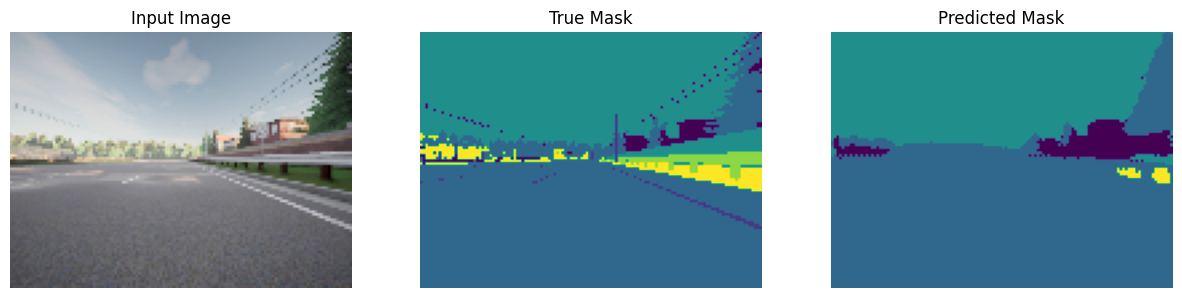

1/1 [==============================] - 0s 25ms/step


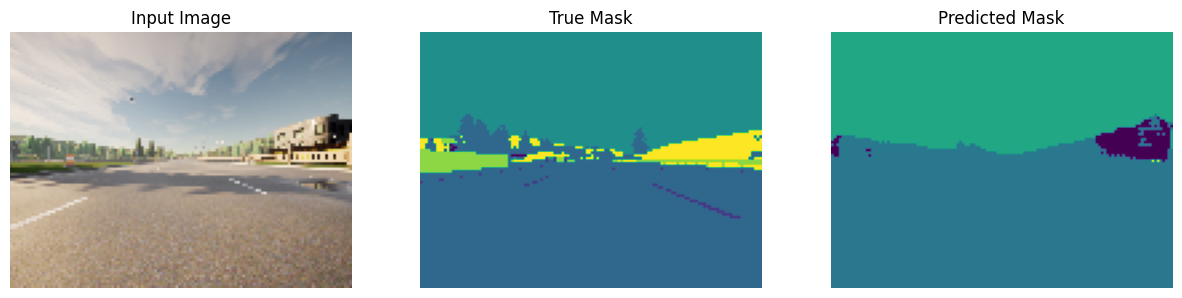

1/1 [==============================] - 0s 24ms/step


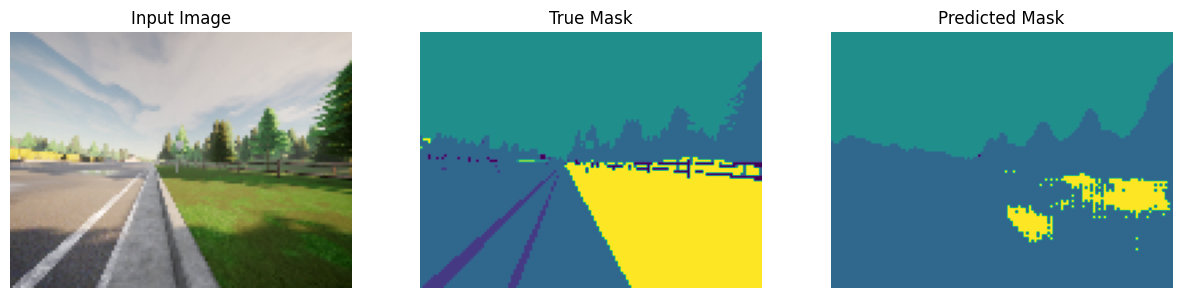

In [97]:
show_predictions(train_dataset, 6)

In [98]:
more_epochs = 20
history_finetune = unet.fit(train_dataset, epochs=10 + more_epochs, initial_epoch=init_epochs)

Epoch 11/30
34/34 [==============================] - 11s 265ms/step - loss: 0.3201 - accuracy: 0.8986
Epoch 12/30
34/34 [==============================] - 10s 262ms/step - loss: 0.3035 - accuracy: 0.9003
Epoch 13/30
34/34 [==============================] - 11s 273ms/step - loss: 0.3038 - accuracy: 0.9035
Epoch 14/30
34/34 [==============================] - 11s 265ms/step - loss: 0.2822 - accuracy: 0.9055
Epoch 15/30
34/34 [==============================] - 11s 267ms/step - loss: 0.2844 - accuracy: 0.9069
Epoch 16/30
34/34 [==============================] - 11s 271ms/step - loss: 0.2663 - accuracy: 0.9117
Epoch 17/30
34/34 [==============================] - 11s 270ms/step - loss: 0.2512 - accuracy: 0.9173
Epoch 18/30
34/34 [==============================] - 11s 259ms/step - loss: 0.2382 - accuracy: 0.9211
Epoch 19/30
34/34 [==============================] - 11s 273ms/step - loss: 0.2328 - accuracy: 0.9229
Epoch 20/30
34/34 [==============================] - 11s 273ms/step - loss: 0.2240

In [99]:
def merge_histories(h1, h2):
    merged = {}
    for key in h1:
        merged[key] = h1[key] + h2[key]
    return merged

In [100]:
combined_history = merge_histories(init_history.history, history_finetune.history)

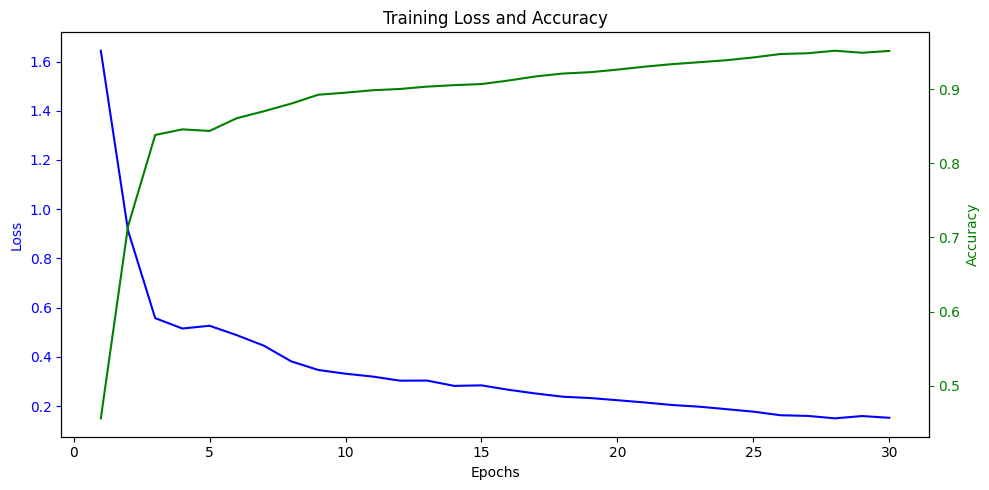

In [101]:
plot_training_history(combined_history)

1/1 [==============================] - 0s 115ms/step


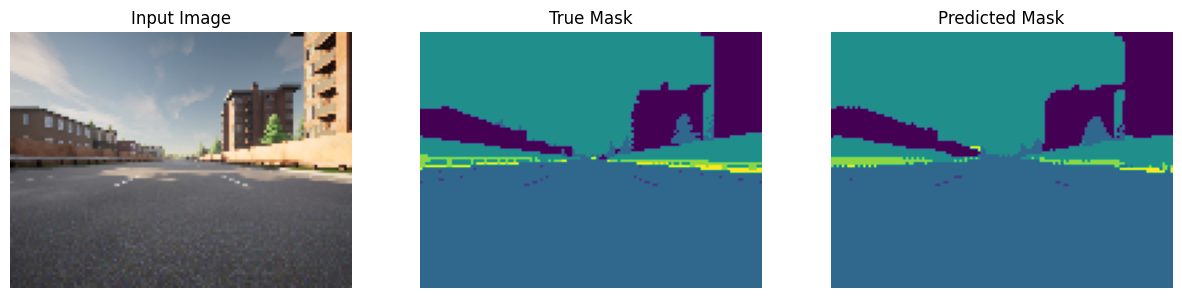

1/1 [==============================] - 0s 114ms/step


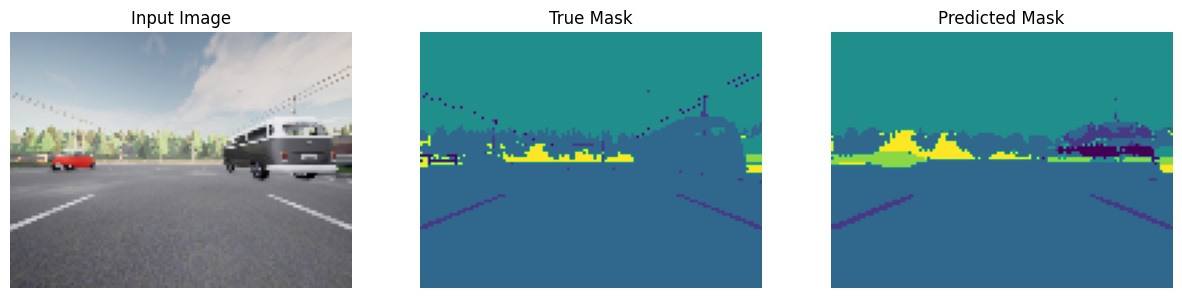

1/1 [==============================] - 0s 25ms/step


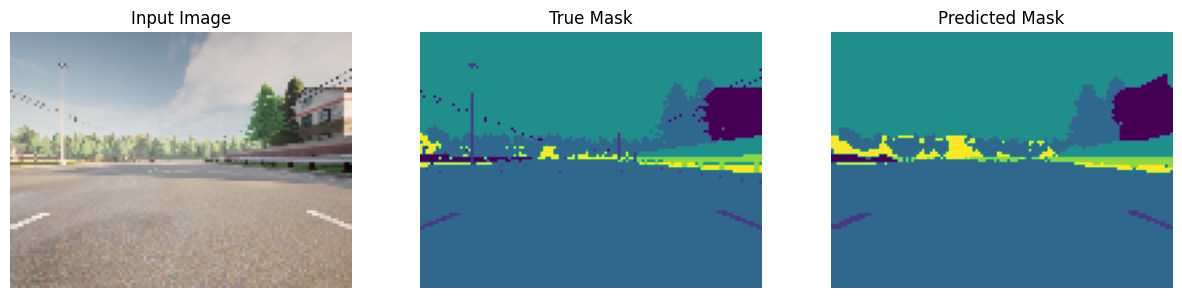

1/1 [==============================] - 0s 25ms/step


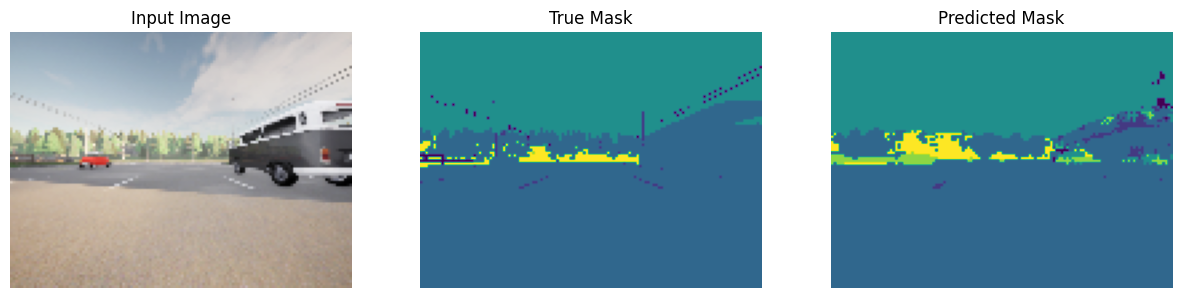

1/1 [==============================] - 0s 25ms/step


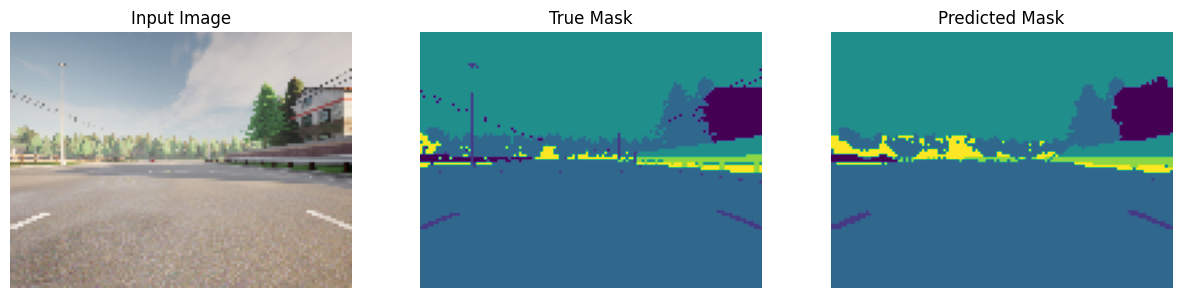

1/1 [==============================] - 0s 116ms/step


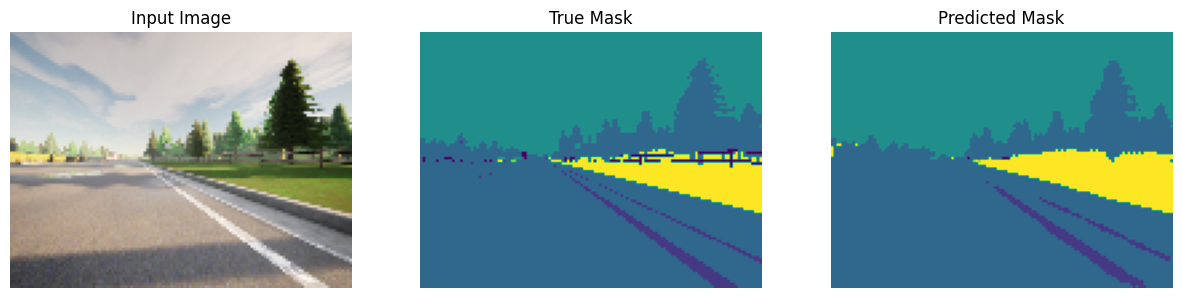

In [102]:
show_predictions(train_dataset, 6)

In [103]:
unet.save('saved_model/unet_model.h5')